In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from time import time
from IPython import display

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d akashguna/large-captcha-dataset

100% 826M/827M [00:44<00:00, 24.1MB/s]
100% 827M/827M [00:44<00:00, 19.6MB/s]


In [ ]:
! unzip large-captcha-dataset.zip
! mv Large_Captcha_Dataset Dataset
! rm ./Dataset/4q2wA.png

Streaming output truncated to the last 5000 lines.
  inflating: Large_Captcha_Dataset/tIBSO.png  
  inflating: Large_Captcha_Dataset/tIRmY.png  
  inflating: Large_Captcha_Dataset/tIZz4.png  
  inflating: Large_Captcha_Dataset/tIkH6.png  
  inflating: Large_Captcha_Dataset/tIrx4.png  
  inflating: Large_Captcha_Dataset/tJ24j.png  
  inflating: Large_Captcha_Dataset/tJ33S.png  
  inflating: Large_Captcha_Dataset/tJD42.png  
  inflating: Large_Captcha_Dataset/tJLFu.png  
  inflating: Large_Captcha_Dataset/tJScx.png  
  inflating: Large_Captcha_Dataset/tJm27.png  
  inflating: Large_Captcha_Dataset/tK26l.png  
  inflating: Large_Captcha_Dataset/tK4Y9.png  
  inflating: Large_Captcha_Dataset/tK683.png  
  inflating: Large_Captcha_Dataset/tK7Ui.png  
  inflating: Large_Captcha_Dataset/tK88m.png  
  inflating: Large_Captcha_Dataset/tK8PF.png  
  inflating: Large_Captcha_Dataset/tKR21.png  
  inflating: Large_Captcha_Dataset/tKXz0.png  
  inflating: Large_Captcha_Dataset/tKjx5.png  
  inflati

In [ ]:
dataset = tf.keras.utils.image_dataset_from_directory(
    directory = "./Dataset",
    labels = None,
    color_mode = "grayscale",
    batch_size = 30,
    image_size = (256, 256) # (height, width)
)
dataset = dataset.map(lambda x: (x - 127.5) / 127.5)

Found 82328 files belonging to 1 classes.


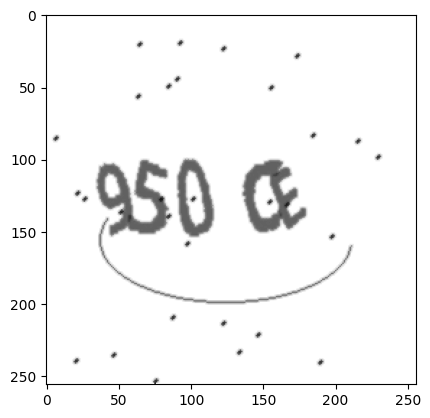

In [ ]:
img, = dataset.take(1)
plt.imshow(img[0], cmap = "gray");

In [ ]:
def Generator():
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.Dense(
            4 * 4 * 256, # Output Units
            use_bias = False,
            input_shape = (100,)
        )
    )
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((4, 4, 256)))
    assert model.output_shape == (None, 4, 4, 256)

    model.add(
        tf.keras.layers.Conv2DTranspose(
            128, # Num Filters
            (3, 3), # Kernel Size
            strides = (1, 1),
            padding = "same",
            use_bias = False
        )
    )
    assert model.output_shape == (None, 4, 4, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(
        tf.keras.layers.Conv2DTranspose(
            64,
            (3, 3),
            strides = (2, 2),
            padding = "same",
            use_bias = False
        )
    )
    assert model.output_shape == (None, 8, 8, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(
        tf.keras.layers.Conv2DTranspose(
            64,
            (4, 4),
            strides = (2, 2),
            padding = "same",
            use_bias = False
        )
    )
    assert model.output_shape == (None, 16, 16, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(
        tf.keras.layers.Conv2DTranspose(
            32,
            (5, 5),
            strides = (4, 4),
            padding = "same",
            use_bias = False
        )
    )
    assert model.output_shape == (None, 64, 64, 32)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(
        tf.keras.layers.Conv2DTranspose(
            1,
            (5, 5),
            strides = (4, 4),
            padding = "same",
            use_bias = False,
            activation = "tanh"
        )
    )
    assert model.output_shape == (None, 256, 256, 1)

    return model

In [ ]:
generator = Generator()

noise = tf.random.uniform(shape = [1, 100])
generatedImage = generator(noise, training = False)

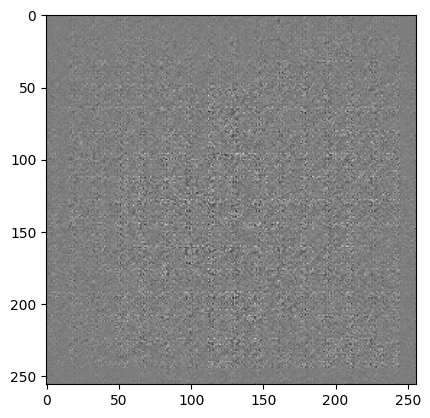

In [ ]:
plt.imshow(generatedImage[0], cmap = "gray");

In [ ]:
def Discriminator():
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.Conv2D(
            64,
            (3, 3),
            strides = (1, 1),
            padding = "same",
            input_shape=[256, 256, 1]
        )
    )
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(
        tf.keras.layers.Conv2D(
            128,
            (4, 4),
            strides = (2, 2),
            padding = "same"
        )
    )
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(
        tf.keras.layers.Conv2D(
            256,
            (5, 5),
            strides = (3, 3),
            padding = "same"
        )
    )
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1)) # Pos: Real, Neg: Fake

    return model

In [ ]:
discriminator = Discriminator()
decision = discriminator(generatedImage)
print(decision)

tf.Tensor([[-5.5410575e-05]], shape=(1, 1), dtype=float32)


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [ ]:
def generatorLoss(outFake):
    return cross_entropy(tf.ones_like(outFake), outFake)

In [ ]:
def discriminatorLoss(outReal, outFake):
    lossReal = cross_entropy(tf.ones_like(outReal), outReal)
    lossFake = cross_entropy(tf.zeros_like(outFake), outFake)
    return lossReal + lossFake

In [ ]:
generatorOptimizer = tf.keras.optimizers.Adam(0.0001)
discriminatorOptimizer = tf.keras.optimizers.Adam(0.0001)

In [ ]:
noiseDim = 100
numGenerated = 16

seed = tf.random.normal([numGenerated, noiseDim])

In [ ]:
def trainStep(images):
    noise = tf.random.normal([30, noiseDim]) # BatchSize = 30

    with tf.GradientTape() as generatorTape, tf.GradientTape() as discriminatorTape:
      generatedImages = generator(noise, training = True)

      outReal = discriminator(images, training = True)
      outFake = discriminator(generatedImages, training = True)

      lossGenerator = generatorLoss(outFake)
      lossDiscriminator = discriminatorLoss(outReal, outFake)

      generatorGradients = generatorTape.gradient(
          lossGenerator, generator.trainable_variables
      )
      discriminatorGradients = discriminatorTape.gradient(
          lossDiscriminator, discriminator.trainable_variables
      )

      generatorOptimizer.apply_gradients(
          zip(generatorGradients, generator.trainable_variables)
      )
      discriminatorOptimizer.apply_gradients(
          zip(discriminatorGradients, discriminator.trainable_variables)
      )

In [ ]:
def createImages(model, epoch, testInput):
  preds = model(testInput, training = False)

  fig = plt.figure(figsize=(14, 14))

  for i in range(preds.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(preds[i], cmap = "gray")
      plt.axis("off")

  plt.savefig(f"image_at_epoch_{epoch}.png")
  plt.show()

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    tic = time()

    for batch in dataset:
      trainStep(batch)

    display.clear_output(wait = True)
    createImages(generator, epoch + 1, seed)

    toc = time()
    print (f"Time for epoch {epoch + 1} is {toc - tic} sec")

  display.clear_output(wait = True)
  createImages(generator, epochs, seed)

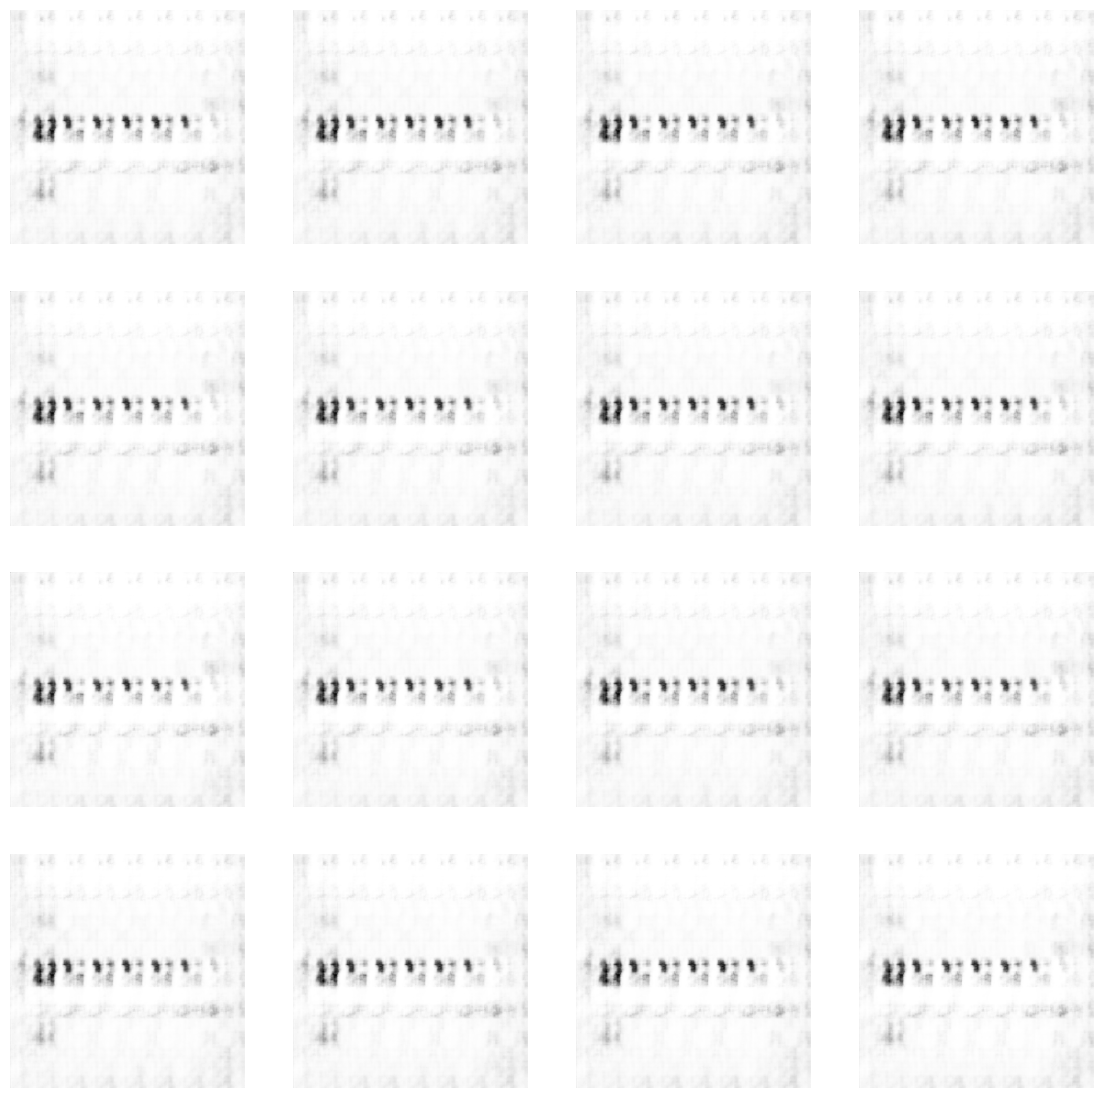

Time for epoch 3 is 2835.433009147644 sec


In [ ]:
train(dataset, epochs = 20)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>